#뉴스타이틀을 통한 뉴스의 토픽 분류

In [1]:
#필요한 라이브러리 import
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import random
import re
random_state = 42

random.seed(random_state)
np.random.seed(random_state)

In [2]:
#구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/뉴스토픽

/content/drive/MyDrive/뉴스토픽


In [4]:
train = pd.read_csv('train_data.csv',engine='python')
test = pd.read_csv('test_data.csv',engine='python')
topic = pd.read_csv('topic_dict.csv')

In [5]:
#결측치 확인
train.isnull().values.any()

False

In [ ]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [ ]:
len(train)

45654

In [6]:
# 정규 표현식을 통한 한글 외 문자제거 전처리 작업
train['title'] = train['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,title,topic_idx
0,0,인천핀란드 항공기 결항휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다구글 조원 들여 전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,클린턴 측근기업 특수관계 조명공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
#훈련데이터를 검증셋과 훈련셋으로 나눠주기 
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20,random_state=2)

In [8]:
#파이썬 한국어 NLP 패키지 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [9]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [10]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.l

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  3570k      0 --:--:-- --:--:-- --:--:-- 11.2M
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

In [11]:
#konlpy에 등록된 시스템 사전 import
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

# 가설 정립
* Word2Vec으로 임베딩벡터를 주어서 LSTM 모델로 NLP 작업을 진행한다면 주제별 분류가 용이할 것이다.
* td-idf으로 벡터화시켜서 LGBM 모델링을 진행하는 것이 분류 정확도가 높을 것이다.



#Word2Vec 단어 분산 기반 임베딩 벡터화


In [ ]:
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec

In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업
okt = Okt()

tokenized_data = []
for sentence in train['title']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

타이틀 최대 길이 : 17
타이틀 평균 길이 : 8.772745940913945


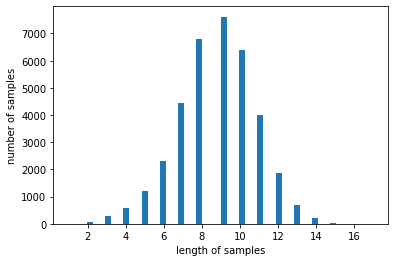

In [ ]:
print('타이틀 최대 길이 :',max(len(title) for title in tokenized_data))
print('타이틀 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(title) for title in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
#Word2Vec을 이용한 문장의 연관관계 분석
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 40, window = 5, min_count = 5, workers = 2, sg = 0)

In [ ]:
model.wv.vectors.shape

(8487, 40)

In [ ]:
#각 토픽과 유사한 단어들 확인
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [ ]:
print('과학 키워드',model.wv.most_similar("과학"))
print('경제 키워드',model.wv.most_similar("경제"))
print('사회 키워드',model.wv.most_similar("사회"))
print('생활문화 키워드',model.wv.most_similar("문화"))
print('세계 키워드',model.wv.most_similar("세계"))
print('스포츠 키워드',model.wv.most_similar("스포츠"))
print('정치 키워드',model.wv.most_similar("정치"))

과학 키워드 [('본부', 0.99853515625), ('사랑', 0.9985215067863464), ('홍보', 0.998495876789093), ('방송통신', 0.9984059929847717), ('출판', 0.9983964562416077), ('방통위', 0.9983261227607727), ('워크숍', 0.9981841444969177), ('폐지', 0.99810791015625), ('동정', 0.9980600476264954), ('및', 0.9980481266975403)]
경제 키워드 [('정책', 0.9927587509155273), ('일방', 0.9884672164916992), ('도부', 0.9883301854133606), ('언론', 0.9881670475006104), ('사드', 0.9861997365951538), ('개혁', 0.9843993782997131), ('정치', 0.9840196371078491), ('긍정', 0.9839896559715271), ('법', 0.9836101531982422), ('초당', 0.9830541610717773)]
사회 키워드 [('발전', 0.995952308177948), ('부정', 0.9957700967788696), ('공', 0.9954240322113037), ('원장', 0.9939259886741638), ('국가', 0.9939096570014954), ('성과', 0.9938341379165649), ('마련', 0.993479311466217), ('인', 0.9931658506393433), ('변화', 0.9931503534317017), ('유영민', 0.9930784106254578)]
생활문화 키워드 [('국제', 0.9946470260620117), ('주년', 0.9928663969039917), ('대한민국', 0.9927111864089966), ('전시회', 0.992010772228241), ('포럼', 0.991953730583

In [ ]:
#train data 선언 및 인코딩 
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = tokenized_data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
#24792개의 데이터 존재 > 빈도수대로 데이터의 숫자부여
#빈도가 낮으면 무시하는 처리 필요
print(tokenizer.word_index)

{'종합': 1, '서': 2, '로': 3, '일': 4, '대통령': 5, '명': 6, '년': 7, '한국': 8, '전': 9, '위': 10, '월': 11, '첫': 12, '만': 13, '등': 14, '대': 15, '적': 16, '삼성': 17, '되다': 18, '이란': 19, '보': 20, '장': 21, '중': 22, '만에': 23, '없다': 24, '당': 25, '출시': 26, '주': 27, '게시판': 28, '감독': 29, '경기': 30, '원': 31, '에서': 32, '개': 33, '트럼프': 34, '보다': 35, '문': 36, '회': 37, '까지': 38, '신간': 39, '것': 40, '안': 41, '지': 42, '억원': 43, '제': 44, '기': 45, '시': 46, '개발': 47, '정부': 48, '부터': 49, '분기': 50, '서울': 51, '고': 52, '을': 53, '투자': 54, '지원': 55, '화': 56, '내': 57, '최고': 58, '개최': 59, '더': 60, '중국': 61, '연': 62, '올해': 63, '사': 64, '민주': 65, '대다': 66, '영업': 67, '세계': 68, '기업': 69, '기술': 70, '수': 71, '최': 72, '차': 73, '성': 74, '현대': 75, '공개': 76, '간': 77, '미국': 78, '속': 79, '새': 80, '금융': 81, '있다': 82, '작년': 83, '코로나': 84, '비': 85, '증권': 86, '다': 87, '상': 88, '최대': 89, '대표': 90, '게임': 91, '인': 92, '김정은': 93, '시장': 94, '신': 95, '북한': 96, '사망': 97, '총리': 98, '서비스': 99, '공': 100, '조': 101, '월드컵': 102, '달': 103, '권': 104, '전자': 1

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 24792
등장 빈도가 2번 이하인 희귀 단어의 수: 12748
단어 집합에서 희귀 단어의 비율: 51.41981284285253
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.114432581060964


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12045


In [ ]:
#검증데이터 토큰화
X_val = []
for sentence in val['title']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_val.append(stopwords_removed_sentence)

In [ ]:
#빈도수를 고려한 단어집합 크기를 적용해서 인코딩 해주기
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
#타깃값 array로 변환
y_train = np.array(train['topic_idx'])
y_val = np.array(val['topic_idx'])

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 12
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 12 이하인 샘플의 비율: 98.05875749527695


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)

In [ ]:
train['topic_idx'].dtype

dtype('int64')

In [ ]:
#LSTM을 사용한 모델 생성
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(7, activation='softmax'))#7개의 주제를 분류하는 소프트맥수 함수

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
456/457 [============================>.] - ETA: 0s - loss: 0.9384 - acc: 0.6727
Epoch 1: val_acc improved from -inf to 0.78522, saving model to best_model.h5
457/457 [==============================] - 11s 8ms/step - loss: 0.9381 - acc: 0.6728 - val_loss: 0.6536 - val_acc: 0.7852
Epoch 2/15
456/457 [============================>.] - ETA: 0s - loss: 0.4856 - acc: 0.8426
Epoch 2: val_acc improved from 0.78522 to 0.81561, saving model to best_model.h5
457/457 [==============================] - 3s 7ms/step - loss: 0.4856 - acc: 0.8426 - val_loss: 0.5570 - val_acc: 0.8156
Epoch 3/15
457/457 [==============================] - ETA: 0s - loss: 0.3864 - acc: 0.8722
Epoch 3: val_acc improved from 0.81561 to 0.82601, saving model to best_model.h5
457/457 [==============================] - 3s 7ms/step - loss: 0.3864 - acc: 0.8722 - val_loss: 0.5395 - val_acc: 0.8260
Epoch 4/15
451/457 [============================>.] - ETA: 0s - loss: 0.3322 - acc: 0.8896
Epoch 4: val_acc did not improve

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

286/286 [==============================] - 1s 3ms/step - loss: 0.5390 - acc: 0.8266

 테스트 정확도: 0.8266


In [ ]:
#최종 테스트 데이터 예측해보기 
test['title'] = test['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
X_test = []
for sentence in test['title']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
#인코딩,패딩,예측
X_test = tokenizer.texts_to_sequences(X_test)
padded = pad_sequences(X_test, maxlen = max_len)
predictions = loaded_model.predict(padded)

In [ ]:
topic = []
for i in range(len(predictions)):
    topic.append(np.argmax(predictions[i]))

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['topic_idx'] = topic

In [ ]:
submission.to_csv('LSTM.csv',index = False)

#TF-IDF 단어 등장횟수 기반 벡터화

In [40]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업
okt = Okt()

def func(text):
    clean = []
    for word in okt.pos(text, stem=True): #어간 추출
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']: #조사, 어미, 구두점 제외 
            clean.append(word[0])
    
    
    return " ".join(clean) 

train['title'] = train['title'].apply(lambda x : func(x))

In [41]:
#훈련셋 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
def split(text):
    tokens_ko = text.split()
    return tokens_ko
tfidf_vect = TfidfVectorizer(tokenizer=split)
tfidf_vect.fit(train['title'])
X_train = tfidf_vect.transform(train['title'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [42]:
y_train = train['topic_idx']
y_val = val['topic_idx']

In [44]:
#검증셋 벡터화
val['title'] = val['title'].apply(lambda x : func(x))
X_val = tfidf_vect.transform(val['title'])

##LGBM 패키지 설치

In [27]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
!cd build
!cmake ./LightGBM
!make -j4

Cloning into 'LightGBM'...
remote: Enumerating objects: 25039, done.
remote: Counting objects: 100% (715/715), done.
remote: Compressing objects: 100% (394/394), done.
remote: Total 25039 (delta 462), reused 509 (delta 316), pack-reused 24324
Receiving objects: 100% (25039/25039), 18.69 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (18408/18408), done.
Checking out files: 100% (481/481), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/drive/MyDrive/뉴스토픽/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.      

In [29]:
%cd /content/LightGBM
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)

[Errno 2] No such file or directory: '/content/LightGBM'
/content/drive/MyDrive/뉴스토픽/LightGBM
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL 

In [30]:
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install — precompile

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

#LGBM 모델링
* Baseline > 모든 parameter 디폴트값

In [45]:
#다중분류 모델 중 비교적 가벼운 LGBM을 이용한 모델링(Default)
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state = 42)

In [46]:
lgbm.fit(X_train,y_train)
pred = lgbm.predict(X_val)
accuracy = accuracy_score(y_val,pred)

print('정확도', accuracy)

정확도 0.7835943489212572


In [47]:
test['title'] = test['title'].apply(lambda x : func(x))
X_test = tfidf_vect.transform(test['title'])

In [67]:
cd /content/drive/MyDrive/뉴스토픽

/content/drive/MyDrive/뉴스토픽


In [68]:
pred = lgbm.predict(X_test)
submission = pd.read_csv('sample_submission.csv')
submission['topic_idx'] = pred
submission.head()

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,2
4,45658,3


In [69]:
submission.to_csv('baseline.csv',index = False)